In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')


# Solving forward and reverse problems with `dolfin` and `dolfin-adjoint`

Here we are solving the two-dimensional Poisson equation as a forward problem 

$$ \nabla^2 u(x, y) = f(x, y) $$

[d1-w6420a-09:2897747] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.d1-w6420a-09.614072/jf.0/3927834624/shared_mem_cuda_pool.d1-w6420a-09 could be created.
[d1-w6420a-09:2897747] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


------------------------
Exact-Dolfin MSE: 5.89e-05


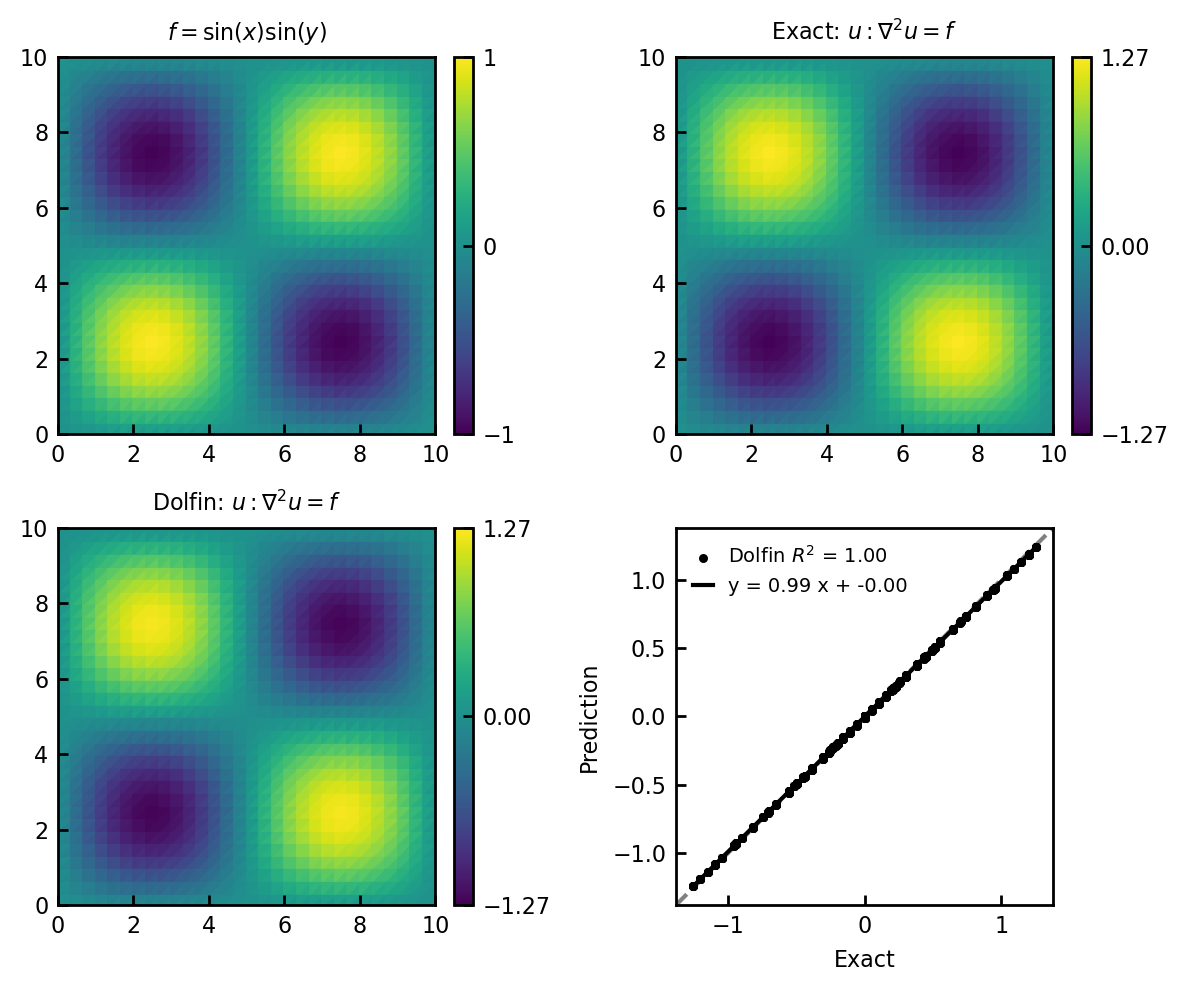

In [2]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

from plot_utils import *

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

# Create mesh and function space
mesh = d_ad.RectangleMesh(
    dlf.Point(0., 0.), dlf.Point(10., 10.), nx=30, ny=30
)
element = ufl.FiniteElement('CG', mesh.ufl_cell(), 1)
function_space = dlf.FunctionSpace(mesh, element)

# Create the forcing function
xmin, ymin = np.min(mesh.coordinates(), axis=0)
xptp, yptp = np.ptp(mesh.coordinates(), axis=0)
xscl, yscl = xptp / (2 * np.pi), yptp / (2 * np.pi)

f = d_ad.Function(function_space)
f_expr = d_ad.Expression(
    "sin((x[0]-xmin)/xscl) * sin((x[1]-ymin)/yscl)",
    xmin=xmin, ymin=ymin, xscl=xscl, yscl=yscl, degree=2
)
f.interpolate(f_expr)

# Create the boundary condition
bc = d_ad.DirichletBC(function_space, d_ad.Constant(0.), 'on_boundary')

# Compute the exact solution
u_exact = d_ad.Function(function_space)
u_expr = d_ad.Expression(
    "-(pow(xscl, 2) * pow(yscl, 2)) / (pow(xscl, 2) + pow(yscl, 2)) * sin((x[0]-xmin)/xscl) * sin((x[1]-ymin)/yscl)",
    xmin=xmin, ymin=ymin, xscl=xscl, yscl=yscl, degree=2
)
u_exact.interpolate(u_expr)
exact = u_exact.compute_vertex_values()

# Solve the forward problem using Dolfin
u = dlf.TrialFunction(function_space)
v = dlf.TestFunction(function_space)

a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

u_dolfin = d_ad.Function(function_space)
d_ad.solve(a == L, u_dolfin, bc)
dlf_sol = u_dolfin.compute_vertex_values()

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(6,5))
ax = ax.flatten()
vmax = np.round((xscl**2 * yscl**2) / (xscl**2 + yscl**2), decimals=2)
vmin=-vmax

# Forcing function
plot_mesh(ax[0], f.compute_vertex_values(), mesh, vmin=-1, vmax=1)
ax[0].set_title(r'$f = \sin(x) \sin(y)$')

# Exact solution
plot_mesh(ax[1], exact, mesh, vmin=vmin, vmax=vmax)
ax[1].set_title(r'Exact: $u: \nabla^2 u = f$')

# Dolfin solution
plot_mesh(ax[2], dlf_sol, mesh, vmin=vmin, vmax=vmax)
ax[2].set_title(r'Dolfin: $u: \nabla^2 u = f$')

plot_with_regression(ax[3], exact, dlf_sol, label='Dolfin', color='black')
ax[3].set(xlabel='Exact', ylabel='Prediction')
xlim, ylim = ax[3].get_xlim(), ax[3].get_ylim()
ax[3].plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
ax[3].set(xlim=xlim, ylim=xlim, aspect='equal')
ax[3].legend()

plt.tight_layout()

print('------------------------')
print(f'Exact-Dolfin MSE: {np.mean(np.power(exact - dlf_sol, 2)):.3g}')

For PDE-constrained optimization, we may want to solve the inverse problem of determining $f$ to produce a given $u$. To achieve, this, we need to first define a loss function

$$ \mathcal{L} = \int_{\Omega} \big(u_{dlf}[f(x, y)] - u_{exact}\big)^2 \, dA $$

Next, we need to minimize this loss by computing its derivative with respect to the input $f(x, y)$. We can do this using the adjoint method or by backpropagation via `dolfin-adjoint`. 

dolfin-adjoint produces a loss of 0.00618 and grad of size (961,)


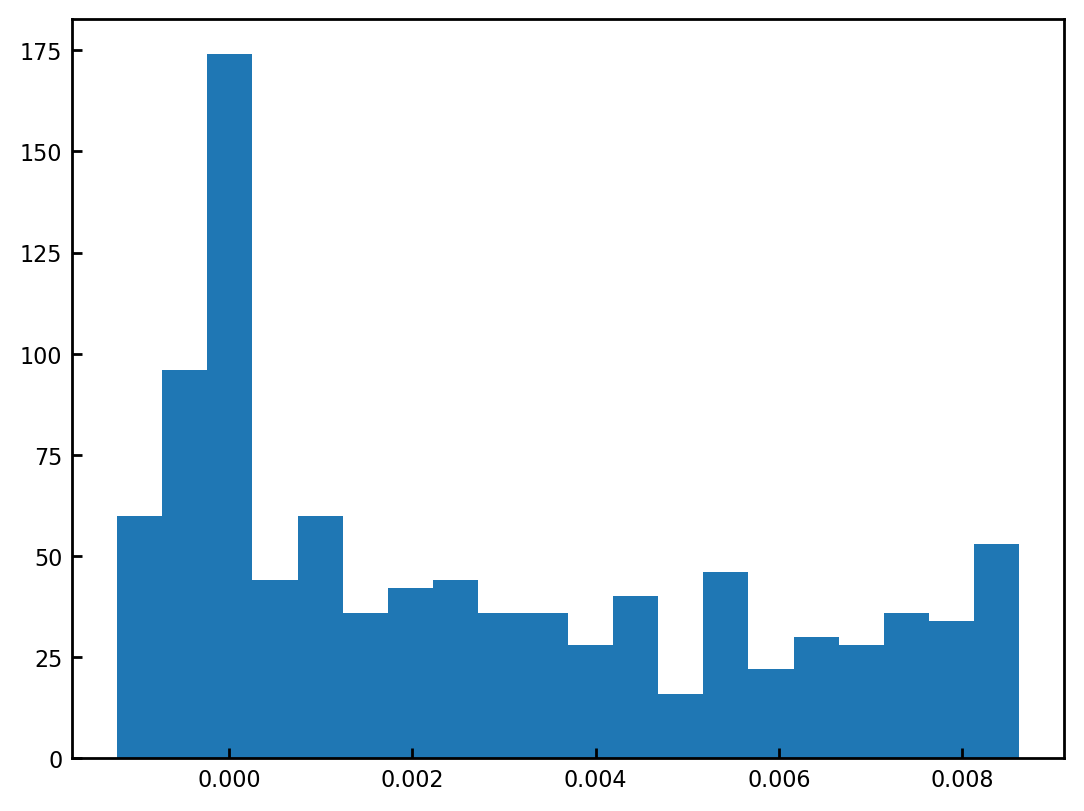

In [3]:
# The dolfin solution is stored in u_dolfin
loss = ufl.inner(u_dolfin - u_exact, u_dolfin - u_exact) * ufl.dx
J = d_ad.assemble(loss)

# Define a control variable that we can tune
control = d_ad.Control(f)

# A reduced functional maps a control value (f) to the provided funtctional (loss)
# This allows us to compute the derivative of the loss w.r.t. f
Jhat = pyad.reduced_functional_numpy.ReducedFunctionalNumPy(J, control)
# We use the Numpy version because it allows us to use an array of scalars as control 
# This will eventually interface better with PyTorch
dolfin_loss = Jhat(f.vector()[:])
dolfin_grad = Jhat.derivative()

print(f'dolfin-adjoint produces a loss of {dolfin_loss:.3g} and grad of size {dolfin_grad.shape}')
plt.hist(dolfin_grad, bins=20);

# Exporting the problem to `scipy.sparse`

Working explicitly with pyadjoint is a bit annoying when we want to throw `torch` into the mix. To get around this for some problems, we can export the assembled problem and solve it using the `scipy.sparse` linear algebra functionality.

We start by noting that Dolfin aims to find the solution $u$ such that

$$ -\int_{\Omega} \nabla u \cdot \nabla v \, dx = \int_{\Omega} f \cdot v \, dx \quad  \forall v \in V $$

Under the hood, Doflin solves this by converting it to a linear algebra problem. More details on this process will come later. For now, it suffices to assume that this is reduced to the form 

$$ A u = L $$

The ordinary least squares solution to this problem is 

$$ u = (A^T A)^{-1} A^T L $$

In reality, $f$ is a vector of function values at discrete points and $L$ is an assembled vector. To get $L$, we also need to assemble the problem $ \int_{\Omega} u \cdot v \, dx = \int_{\Omega} f \cdot v\, dx $ into a linear problem

------------------------
Exact-Matrix MSE: 5.04e-06


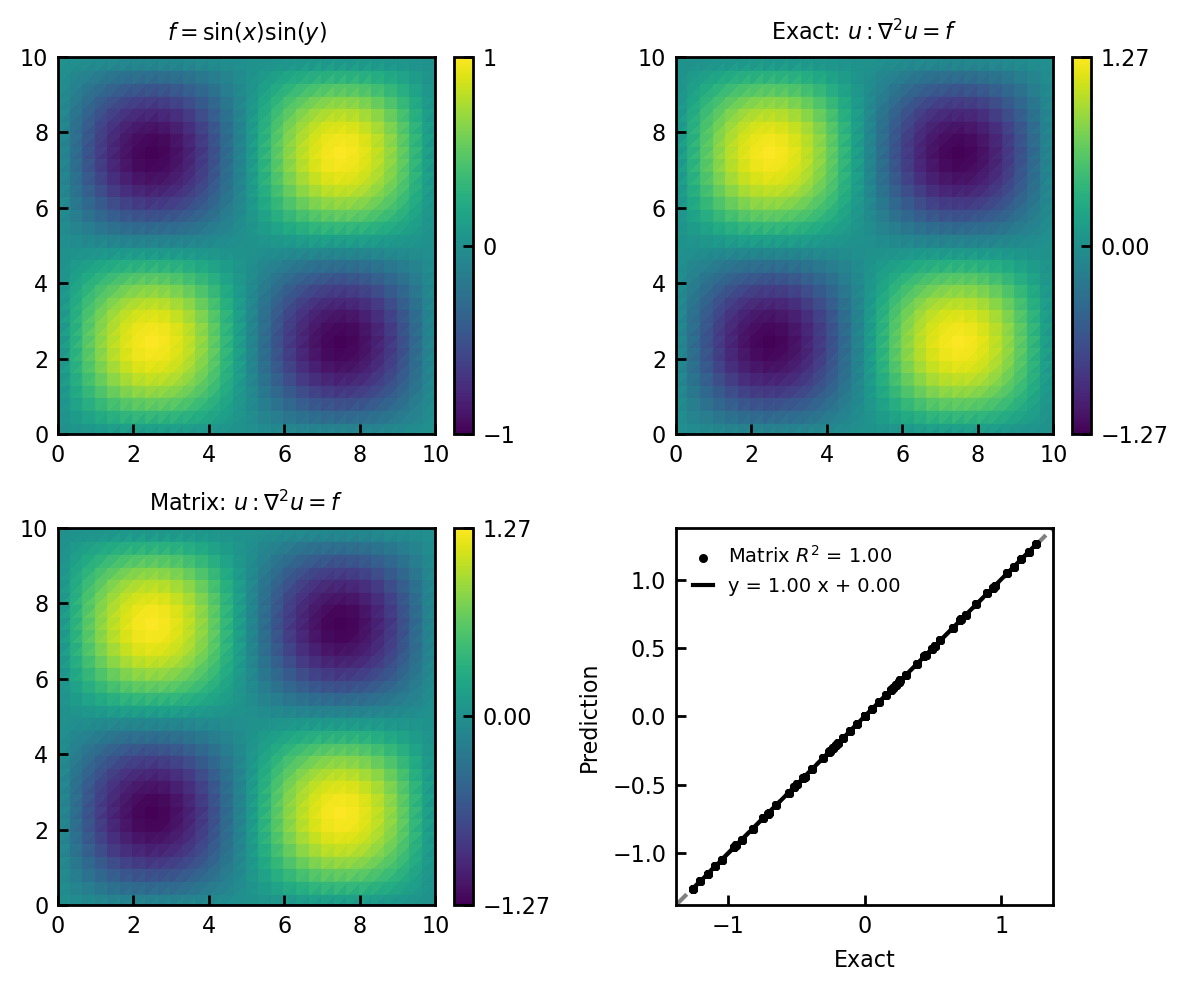

In [10]:
import scipy
from scipy import sparse

d2v = dlf.dof_to_vertex_map(function_space)
v2d = dlf.vertex_to_dof_map(function_space)

def get_torch_solution(f):
    # Assemble the problem again
    a = - ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx #RHS
    A = dlf.assemble(a)
    bc.apply(A)

    # Account for internal scaling
    diag = dlf.assemble(v * ufl.dx)[:]

    # Convert to scipy sparse matrix
    A = sparse.csr_matrix(A.array())
    rhs = sparse.linalg.inv(A.T @ A) @ A.T

    # Convert relevant variables to torch
    rhs = torch.FloatTensor(rhs.todense())
    diag = torch.FloatTensor(diag)

    f_torch = torch.FloatTensor(f.vector()[:])
    f_torch = torch.nn.Parameter(f_torch, requires_grad=True)

    # Solve the forward linear algebra problem
    u_torch = rhs @ f_torch * diag

    return u_torch, f_torch, diag

u_torch, f_torch, diag = get_torch_solution(f)

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(6,5))
ax = ax.flatten()
vmax = np.round((xscl**2 * yscl**2) / (xscl**2 + yscl**2), decimals=2)
vmin=-vmax

# Forcing function
plot_mesh(ax[0], f.compute_vertex_values(), mesh, vmin=-1, vmax=1)
ax[0].set_title(r'$f = \sin(x) \sin(y)$')

# Exact solution
plot_mesh(ax[1], exact, mesh, vmin=vmin, vmax=vmax)
ax[1].set_title(r'Exact: $u: \nabla^2 u = f$')

# Matrix solution solution
# mat_sol is ordered according to dofs - vertex_to_dof_map gives the corresponding dof for each vertex
plot_mesh(ax[2], u_torch[v2d].detach().numpy(), mesh, vmin=vmin, vmax=vmax)
ax[2].set_title(r'Matrix: $u: \nabla^2 u = f$')

plot_with_regression(ax[3], exact, u_torch[v2d].detach().numpy(), label='Matrix', color='black')
ax[3].set(xlabel='Exact', ylabel='Prediction')
xlim, ylim = ax[3].get_xlim(), ax[3].get_ylim()
ax[3].plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
ax[3].set(xlim=xlim, ylim=xlim, aspect='equal')
ax[3].legend()

plt.tight_layout()

print('------------------------')
print(f'Exact-Matrix MSE: {np.mean(np.power(u_exact.vector()[:] - u_torch.detach().numpy(), 2)):.3g}')

To handle the reverse problem, we can backpropagate using `torch`. This does not quite work yet but I'm trying to figure it out

dolfin-adjoint produces a loss of 0.00618
torch-autograd produces a loss of 0.00629


/tmp/ipykernel_3457338/3451117697.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend()


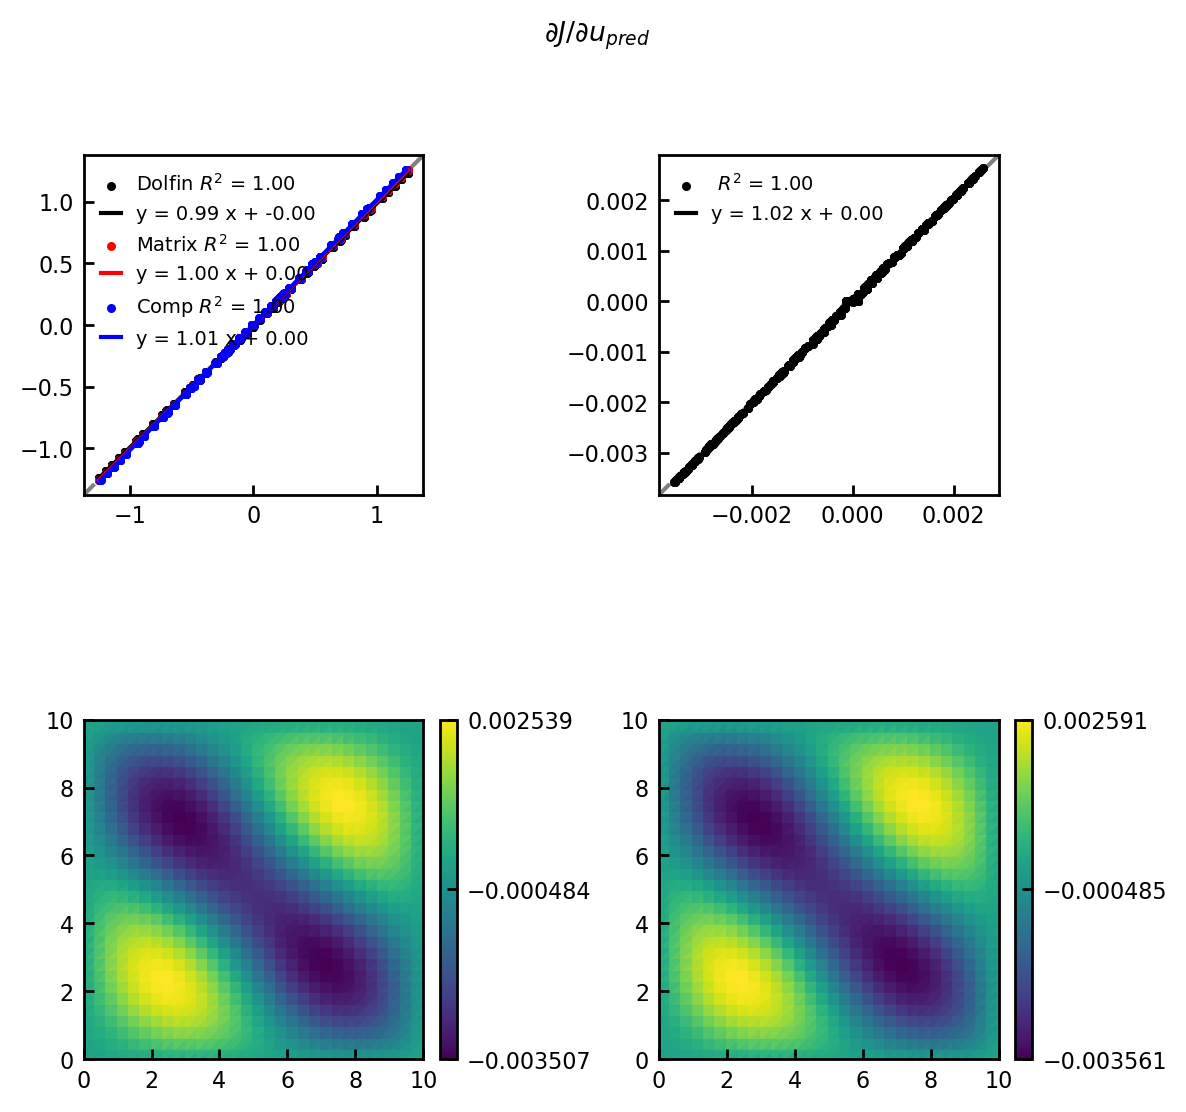

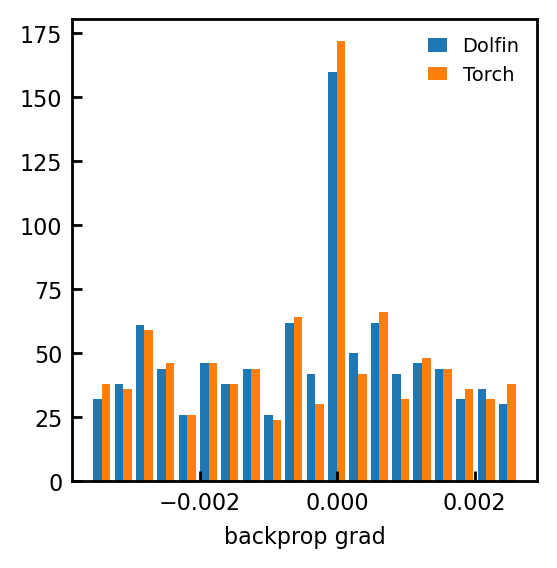

In [38]:
# Dolfin gradients
loss = ufl.inner(u_dolfin - u_exact, u_dolfin - u_exact) * ufl.dx
Jhat = pyad.reduced_functional_numpy.ReducedFunctionalNumPy(d_ad.assemble(loss), d_ad.Control(u_dolfin))
dolfin_loss = Jhat(u_dolfin.vector()[:])
dolfin_grad = Jhat.derivative(u_dolfin.vector()[:])
print(f'dolfin-adjoint produces a loss of {dolfin_loss:.3g}')

# Torch gradients
u_torch, f_torch, diag = get_torch_solution(f)

u_dolfin_torch = torch.nn.Parameter(torch.FloatTensor(u_dolfin.vector()[:]), requires_grad=True)
u_exact_torch = torch.FloatTensor(u_exact.vector()[:])

torch_loss = torch.sum( (u_dolfin_torch - u_exact_torch) * (u_dolfin_torch - u_exact_torch) * diag)
torch_loss.backward()
torch_grad = u_dolfin_torch.grad.numpy()

print(f'torch-autograd produces a loss of {torch_loss.item():.3g}')

fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax=ax.flatten()

plot_with_regression(ax[0], u_exact_torch.numpy(), u_dolfin.vector()[:], label='Dolfin', color='black')
plot_with_regression(ax[0], u_exact_torch.numpy(), u_torch.detach(), label='Matrix', color='red')
plot_with_regression(ax[0], u_dolfin.vector()[:], u_torch.detach(), label='Comp', color='blue')
plot_with_regression(ax[1], dolfin_grad, torch_grad)

plot_mesh(ax[2], dolfin_grad[v2d], mesh)
plot_mesh(ax[3], torch_grad[v2d], mesh)

for a in ax:
    a.legend()
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
    a.set(xlim=xlim, ylim=xlim, aspect='equal')

fig.suptitle(r'$\partial J / \partial u_{pred}$')

plt.tight_layout()

ax = plt.figure(figsize=(3,3)).gca()
ax.hist([dolfin_grad, torch_grad], bins=20, label=['Dolfin', 'Torch']);
ax.set_xlabel('backprop grad')
ax.legend()

dolfin-adjoint produces a loss of 0.00618
torch-autograd produces a loss of 0.000538


/tmp/ipykernel_3457338/4058405670.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend()
/tmp/ipykernel_3457338/4058405670.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


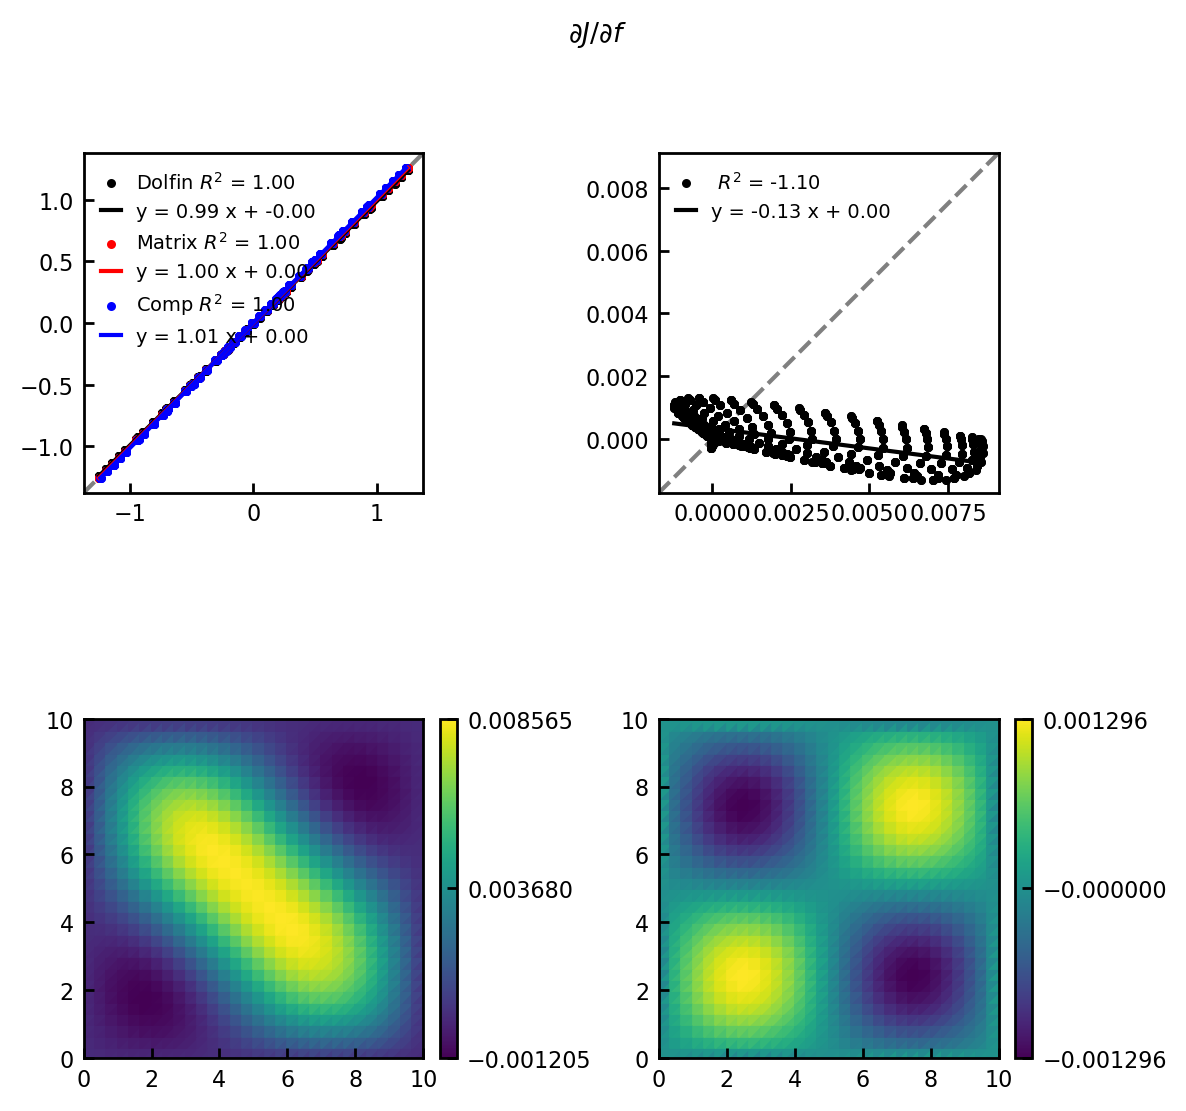

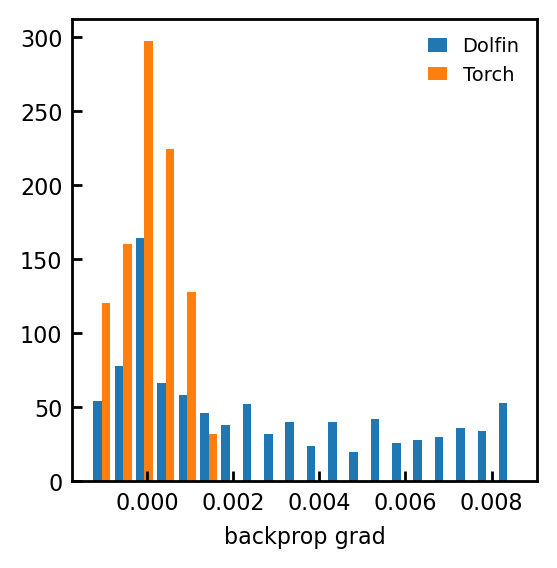

In [41]:
# Dolfin gradients
u = dlf.TrialFunction(function_space)
v = dlf.TestFunction(function_space)

a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

u_dolfin = d_ad.Function(function_space)
d_ad.solve(a == L, u_dolfin, bc)
loss = ufl.inner(u_dolfin - u_exact, u_dolfin - u_exact) * ufl.dx
Jhat = pyad.reduced_functional_numpy.ReducedFunctionalNumPy(d_ad.assemble(loss), d_ad.Control(f))
dolfin_loss = Jhat(f.vector()[:])
dolfin_grad = Jhat.derivative(f.vector()[:])
print(f'dolfin-adjoint produces a loss of {dolfin_loss:.3g}')

# Torch gradients
u_exact_torch = torch.FloatTensor(u_exact.vector()[:])
u_torch, f_torch, diag = get_torch_solution(f)

torch_loss = torch.sum( (u_torch - u_exact_torch) * (u_torch - u_exact_torch) * diag)
torch_loss.backward()
torch_grad = f_torch.grad.numpy()

print(f'torch-autograd produces a loss of {torch_loss.item():.3g}')

fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax=ax.flatten()

plot_with_regression(ax[0], u_exact_torch.numpy(), u_dolfin.vector()[:], label='Dolfin', color='black')
plot_with_regression(ax[0], u_exact_torch.numpy(), u_torch.detach(), label='Matrix', color='red')
plot_with_regression(ax[0], u_dolfin.vector()[:], u_torch.detach(), label='Comp', color='blue')
plot_with_regression(ax[1], dolfin_grad, torch_grad)

plot_mesh(ax[2], dolfin_grad[v2d], mesh)
plot_mesh(ax[3], torch_grad[v2d], mesh)

for a in ax:
    a.legend()
    xlim, ylim = a.get_xlim(), a.get_ylim()
    a.plot(xlim, xlim, color='grey', linestyle='--', zorder=-1)
    a.set(xlim=xlim, ylim=xlim, aspect='equal')

fig.suptitle(r'$\partial J / \partial f$')

plt.tight_layout()

ax = plt.figure(figsize=(3,3)).gca()
ax.hist([dolfin_grad, torch_grad], bins=20, label=['Dolfin', 'Torch']);
ax.set_xlabel('backprop grad')
ax.legend()